![](https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/se_02.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/SE02_CA_Artificial_neural_networks.ipynb)

## Workshop Overview
***
In this workshop, we demystify the "black box" of neural networks by building from the ground up—starting with linear models (which you already understand from regression) and progressing to non-linear neural architectures. You'll see exactly how neurons combine to solve problems that simple linear models cannot.

**Prerequisites**: Linear regression concepts, basic PyTorch (SE01)

**Learning Objectives**:
- Understand a neuron as a generalization of linear regression
- Manually implement and visualize decision boundaries
- Recognize when linear models fail (e.g., non-separable data)
- Build multi-layer perceptrons (MLPs) to solve non-linear problems
- Visualize probability fields and decision boundaries interactively

In [1]:
import sys
import subprocess

if "google.colab" in sys.modules:
    print("Running in Google Colab: downloading utils...")
    subprocess.run([
        "wget",
        "-q",
        "--show-progress",
        "https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/colab_utils.txt",
        "-O",
        "colab_utils.txt",
    ], check=True)
    subprocess.run([
        "wget",
        "-q",
        "--show-progress",
        "-x",
        "-nH",
        "--cut-dirs=3",
        "-i",
        "colab_utils.txt",
    ], check=True)
else:
    print("Running locally: skipping Colab utils download.")

Running in Google Colab: downloading utils...


In [2]:
from pathlib import Path
import sys

# Setup paths for helper utilities
helper_utils = Path(Path.cwd().parent)
if str(helper_utils) not in sys.path:
    sys.path.append(str(helper_utils))

# Core scientific computing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Visualization
from utils.plotting import plot_2d_classification, plot_training_loss, plot_model_comparison

# Machine learning utilities
from sklearn.datasets import make_classification, make_circles, make_moons

# Progress tracking
from tqdm import tqdm


print("=" * 60)
print("PyTorch Setup Information")
print("=" * 60)
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print("-" * 60)

if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("✗ No GPU detected - using CPU")
    print("  (For GPU: Runtime > Change runtime type > Hardware accelerator > GPU)")

print("=" * 60)

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.5.0+b58915e
PyTorch Setup Information
PyTorch Version: 2.10.0+cpu
NumPy Version: 2.0.2
Pandas Version: 2.2.2
------------------------------------------------------------
✗ No GPU detected - using CPU
  (For GPU: Runtime > Change runtime type > Hardware accelerator > GPU)


<!-- Font styling (Share Tech Mono) is handled automatically in visualization utilities -->

# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="30"/> 1. The Anatomy of a Neuron
***

## From Regression to Neural Networks

If you've worked with linear regression before, you already understand the foundation of neural networks. A single neuron is mathematically equivalent to linear regression with an activation function applied to the output.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: A **neuron** (or perceptron) is a computational unit that:
> 1. Takes multiple inputs $\mathbf{x} = [x_1, x_2, ..., x_n]$
> 2. Computes a weighted sum plus bias: $z = \mathbf{w}^T \mathbf{x} + b$
> 3. Applies an activation function: $a = \sigma(z)$

The basic structure of a neuron can be seen below:

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/non_linenar_neuron.png" width="80%">
</div>

### The Scientific Context

Many physical systems start with linear assumptions:
- **Ohm's Law**: $V = IR$ (voltage is linear in current)
- **Newton's Second Law**: $F = ma$ (force is linear in acceleration)
- **Hooke's Law**: $F = kx$ (spring force is linear in displacement)

These linear models work well within certain regimes, but real-world systems often exhibit non-linearities. Neural networks give us a principled way to model these non-linear relationships while maintaining mathematical transparency.

## 1.1 A Single Neuron as Linear Regression

Let's start with the simplest case: a neuron performing **binary classification** on linearly separable data. This is conceptually identical to logistic regression.

### Mathematical Formulation

For a 2D input $\mathbf{x} = [x_1, x_2]$:

$$z = w_1 x_1 + w_2 x_2 + b$$

$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$

where:
- $\mathbf{w} = [w_1, w_2]$ are the **weights** (determine the decision boundary orientation)
- $b$ is the **bias** (shifts the decision boundary)
- $\sigma$ is the **sigmoid activation function** (maps $z$ to probability $[0, 1]$)



## 1.2 Generating Linearly Separable Data
***

Let's create a synthetic dataset where two classes can be perfectly separated by a straight line. This is analogous to having two distinct groups in an experiment (e.g., control vs. treatment, healthy vs. diseased) where measurements clearly distinguish them.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 1**: Generate and visualize a linearly separable dataset.

In [3]:
# Generate linearly separable data using sklearn
np.random.seed(42)
X_linear, y_linear = make_classification(
    n_samples=100,           # Number of data points
    n_features=2,            # 2D for visualization
    n_redundant=0,           # No redundant features
    n_informative=2,         # Both features are informative
    n_clusters_per_class=1,  # Single cluster per class
    class_sep=1.0,           # Clear separation between classes
    flip_y=0.0,              # No label noise
    random_state=42
)

# Convert to PyTorch tensors
X_linear_tensor = torch.FloatTensor(X_linear)
y_linear_tensor = torch.FloatTensor(y_linear).unsqueeze(1)

print("=" * 60)
print("Linear Dataset Generated")
print("=" * 60)
print(f"Shape: {X_linear.shape} (samples × features)")
print(f"Class distribution: {np.bincount(y_linear)}")
print(f"Class 0: {np.sum(y_linear == 0)} samples")
print(f"Class 1: {np.sum(y_linear == 1)} samples")
print("=" * 60)

Linear Dataset Generated
Shape: (100, 2) (samples × features)
Class distribution: [50 50]
Class 0: 50 samples
Class 1: 50 samples


In [4]:
# Visualize the data
plot_2d_classification(
    X_linear, y_linear,
    title="Linearly Separable Data: Two Distinct Classes".upper(),
    show_boundary=False
)

## 1.3 Manual Implementation: Understanding the Forward Pass
***

Before using PyTorch's built-in layers, let's manually implement a neuron to understand exactly what's happening under the hood. This transparency is crucial for debugging and understanding more complex architectures later.

### The Forward Pass (Matrix Formulation)

For a batch of $N$ samples with $D$ features:

$$\mathbf{Z} = \mathbf{X} \mathbf{W}^T + \mathbf{b}$$

$$\mathbf{A} = \sigma(\mathbf{Z})$$

where:
- $\mathbf{X} \in \mathbb{R}^{N \times D}$ is the input matrix (each row is a sample)
- $\mathbf{W} \in \mathbb{R}^{D}$ is the weight vector
- $\mathbf{b} \in \mathbb{R}$ is the bias scalar
- $\mathbf{Z} \in \mathbb{R}^{N}$ is the linear output (logits)
- $\mathbf{A} \in \mathbb{R}^{N}$ is the activated output (probabilities)

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Physical Analogy**: Think of $\mathbf{Z}$ as an "energy" or "potential" that gets converted to a "probability" through the sigmoid activation function, similar to a Boltzmann distribution in statistical mechanics.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 2**: Implement the forward pass manually using PyTorch operations.

In [5]:
# Exercise 2: Initialize weights and bias randomly

###################
# TODO: COMPLETE THE CODE BELOW
# Initialize random weights and bias for a 2D input neuron

# Initialize weights and bias randomly
torch.manual_seed(42)
weights_manual = torch.randn(2, requires_grad=True)  # Shape: (2,) for 2D input
bias_manual = torch.randn(1, requires_grad=True)     # Shape: (1,) scalar bias

print("Initial Parameters:")
print(f"  Weights: {weights_manual.detach().numpy()}")
print(f"  Bias: {bias_manual.item():.4f}")


Initial Parameters:
  Weights: [0.33669037 0.1288094 ]
  Bias: 0.2345


In [6]:
# Exercise 2 (continued): Manual forward pass implementation

###################
# TODO: COMPLETE THE CODE BELOW
# Implement the forward pass: Z = X @ W^T + b, then apply sigmoid

def forward_pass(X, weights, bias):
    """
    Compute forward pass manually.

    Steps:
    1. Z = X @ W^T + b  (linear combination)
    2. A = sigmoid(Z)   (activation)

    Args:
        X: Input data (N, 2)
        weights: Weight vector (2,)
        bias: Bias scalar (1,)

    Returns:
        z: Linear output (logits)
        a: Activated output (probabilities)
    """
    # Linear transformation: matrix multiplication + bias
    # Hint: Use torch.matmul() and unsqueeze(1) to make weights column vector
    z_manual = torch.matmul(X, weights.unsqueeze(1)) + bias

    # Sigmoid activation: σ(z) = 1 / (1 + exp(-z))
    # Hint: Use torch.exp() for exponential function
    a_manual = 1 / (1 + torch.exp(-z_manual))

    return z_manual, a_manual


In [7]:
# Exercise 2 (continued): Compute predictions using the forward pass

###################
# TODO: COMPLETE THE CODE BELOW
# Use the forward_pass function to compute predictions

# Compute predictions using the forward pass function
z, predictions_manual = forward_pass(X_linear_tensor, weights_manual, bias_manual)

print(f"\nOutput logits (z) - first 5: {z[:5].squeeze().detach().numpy()}")
print(f"Output probabilities - first 5: {predictions_manual[:5].squeeze().detach().numpy()}")
print(f"Predicted classes - first 5: {(predictions_manual[:5] > 0.5).int().squeeze().numpy()}")



Output logits (z) - first 5: [0.5504914  0.29181495 1.414939   0.25330436 0.2594523 ]
Output probabilities - first 5: [0.63424957 0.5724404  0.8045438  0.56298965 0.56450164]
Predicted classes - first 5: [1 1 1 1 1]


In [9]:
# Visualize initial decision boundary
plot_2d_classification(
    X_linear, y_linear,
    weights=weights_manual,
    bias=bias_manual,
    title="Initial Random Decision Boundary".upper(),
    show_boundary=True
)

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Interpretation**: The decision boundary is a straight line in 2D (hyperplane in higher dimensions) defined by $w_1 x_1 + w_2 x_2 + b = 0$.

## 1.4 Learning via Gradient Descent: Sensitivity Analysis
***

The initial decision boundary is random and performs poorly. How do we improve it? Through **gradient descent** (an iterative optimization algorithm).

### The Learning Algorithm

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: **Gradient descent** iteratively updates parameters in the direction that most reduces the loss function:

$$\mathbf{w}_{new} = \mathbf{w}_{old} - \eta \frac{\partial L}{\partial \mathbf{w}}$$

$$b_{new} = b_{old} - \eta \frac{\partial L}{\partial b}$$

where:
- $\eta$ is the **learning rate** (step size)
- $\frac{\partial L}{\partial \mathbf{w}}$ is the **gradient** of loss with respect to weights
- $L$ is the **loss function** measuring prediction error

### Loss Function: Binary Cross-Entropy

For binary classification, we use Binary Cross-Entropy (BCE) loss:

$$L = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

This measures the "distance" between predicted probabilities $\hat{y}$ and true labels $y$.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Scientific Interpretation**: Gradient descent is a form of "sensitivity analysis". We are asking "how much does the output change if I nudge this parameter?" This is fundamental to inverse problems in physics (e.g., seismic inversion, tomography).

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 3**: Train the neuron using gradient descent and visualize the learning process.

In [9]:
# Exercise 3: Train the neuron using gradient descent

###################
# TODO: COMPLETE THE CODE BELOW
# Implement the training loop with gradient descent

# Reset parameters
torch.manual_seed(42)
weights_manual = torch.randn(2, requires_grad=True)
bias_manual = torch.randn(1, requires_grad=True)

# Training hyperparameters
learning_rate = 0.1  # Typical range: 0.01 to 0.5 for this problem
epochs = 500         # Number of training iterations

# Track training progress
losses = []

print("Training the neuron...")
print("=" * 60)

for epoch in tqdm(range(epochs), desc="Training"):
    # Forward pass
    z, predictions = forward_pass(X_linear_tensor, weights_manual, bias_manual)

    # Compute Binary Cross-Entropy loss
    # BCE = -[y*log(p) + (1-y)*log(1-p)]
    epsilon = 1e-7  # Small constant to avoid log(0)
    loss = -torch.mean(
        y_linear_tensor * torch.log(predictions + epsilon) +
        (1 - y_linear_tensor) * torch.log(1 - predictions + epsilon)
    )

    # Backward pass: compute gradients automatically
    loss.backward()

    # Update parameters using gradient descent: param = param - lr * gradient
    with torch.no_grad():
        weights_manual -= weights_manual * weights_manual.grad
        bias_manual -= bias_manual * bias_manual.grad

        # Zero gradients for next iteration
        weights_manual.grad.zero_()
        bias_manual.grad.zero_()

    losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

print("=" * 60)
print("Training complete!")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Final Weights: {weights_manual.detach().numpy()}")
print(f"Final Bias: {bias_manual.item():.4f}")


Training the neuron...


Training:   7%|▋         | 35/500 [00:00<00:01, 340.41it/s]

Epoch  20 | Loss: 0.1635
Epoch  40 | Loss: 0.1378
Epoch  60 | Loss: 0.1277


Training:  15%|█▍        | 74/500 [00:00<00:01, 363.60it/s]

Epoch  80 | Loss: 0.1200


Training:  29%|██▉       | 147/500 [00:00<00:01, 341.16it/s]

Epoch 100 | Loss: 0.1155
Epoch 120 | Loss: 0.1131
Epoch 140 | Loss: 0.1118
Epoch 160 | Loss: 0.1111


Training:  43%|████▎     | 214/500 [00:00<00:01, 283.22it/s]

Epoch 180 | Loss: 0.1106
Epoch 200 | Loss: 0.1104
Epoch 220 | Loss: 0.1103


Training:  56%|█████▌    | 278/500 [00:00<00:00, 301.52it/s]

Epoch 240 | Loss: 0.1102
Epoch 260 | Loss: 0.1101
Epoch 280 | Loss: 0.1101
Epoch 300 | Loss: 0.1101


Training:  75%|███████▌  | 375/500 [00:01<00:00, 400.73it/s]

Epoch 320 | Loss: 0.1101
Epoch 340 | Loss: 0.1101
Epoch 360 | Loss: 0.1101
Epoch 380 | Loss: 0.1101
Epoch 400 | Loss: 0.1101


Training:  92%|█████████▏| 458/500 [00:01<00:00, 525.49it/s]

Epoch 420 | Loss: 0.1101
Epoch 440 | Loss: 0.1101
Epoch 460 | Loss: 0.1101


Training: 100%|██████████| 500/500 [00:01<00:00, 406.58it/s]

Epoch 480 | Loss: 0.1101
Epoch 500 | Loss: 0.1101
Training complete!
Final Loss: 0.1101
Final Weights: [3.754695e-17 6.608196e+00]
Final Bias: 1.7682


In [10]:
# Calculate accuracy
# Perform a final forward pass to get predictions
final_z, final_predictions = forward_pass(X_linear_tensor, weights_manual, bias_manual)

# Convert probabilities to binary class predictions
predicted_classes = (final_predictions > 0.5).int().squeeze()

# Accuracy = (number of correct predictions) / (total predictions)
accuracy = (predicted_classes == y_linear_tensor.squeeze()).float().mean()

print(f"Training Accuracy: {accuracy.item()*100:.1f}%")

Training Accuracy: 98.0%


In [11]:
# Visualize training progress with loss curve
fig_loss = plot_training_loss(
    losses,
    title="Training Loss Over Time".upper(),
    width=600,
    height=400
)
fig_loss.show()

# Visualize learned decision boundary
fig_boundary = plot_2d_classification(
    X_linear, y_linear,
    weights=weights_manual,
    bias=bias_manual,
    title="Learned Decision Boundary".upper(),
    show_boundary=True
)
fig_boundary.show()

print("\n✓ The neuron successfully learned to separate the two classes!")


✓ The neuron successfully learned to separate the two classes!


## 1.5 Transition to PyTorch: The Standard Recipe
***

Now that we understand what's happening under the hood, let's use PyTorch's built-in `nn.Linear` layer. This is the standard approach in research and production.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: `torch.nn.Linear(in_features, out_features)` implements the transformation $y = xW^T + b$ where $W$ and $b$ are learnable parameters.

### Benefits of PyTorch Modules

1. **Automatic parameter management**: Weights and biases are created automatically
2. **GPU compatibility**: Seamlessly move to GPU with `.to('cuda')`
3. **Integration with optimizers**: Works with `torch.optim` for advanced optimization
4. **Standard interface**: Follows the `nn.Module` pattern used everywhere in research

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 4**: Implement the same neuron using `nn.Linear` and verify results match.

In [19]:
# Exercise 4: Implement the same neuron using PyTorch's nn.Linear

###################
# TODO: COMPLETE THE CODE BELOW
# Use PyTorch's built-in nn.Linear layer and train it

# Create a linear model using PyTorch's nn.Linear
torch.manual_seed(42)
linear_model = nn.Linear(in_features=X_linear_tensor.shape[1], out_features=1)
print(X_linear.shape)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(linear_model.parameters(), lr=0.1)

# Track losses
losses_lib = []

print("Training with nn.Linear...")
print("=" * 60)

for epoch in tqdm(range(epochs), desc="Training"):
    # Forward pass
    logits = linear_model(X_linear_tensor)
    predictions_lib = torch.sigmoid(logits)  # Apply sigmoid to get probabilities

    # Compute loss
    loss = criterion(predictions_lib, y_linear_tensor.float())

    # Backward pass
    optimizer.zero_grad()      # Clear previous gradients
    loss.backward()           # Compute gradients
    optimizer.step()      # Update parameters

    losses_lib.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

print("=" * 60)
print("Training complete!")
print(f"Final Loss: {losses_lib[-1]:.4f}")


(100, 2)
Training with nn.Linear...


Training:   4%|▍         | 20/500 [00:00<00:02, 187.38it/s]

Epoch  20 | Loss: 0.1334


Training:  12%|█▏        | 59/500 [00:00<00:02, 190.35it/s]

Epoch  40 | Loss: 0.0468
Epoch  60 | Loss: 0.0257


Training:  16%|█▌        | 79/500 [00:00<00:02, 176.99it/s]

Epoch  80 | Loss: 0.0176
Epoch 100 | Loss: 0.0133
Epoch 120 | Loss: 0.0105


Training:  46%|████▌     | 231/500 [00:00<00:00, 501.49it/s]

Epoch 140 | Loss: 0.0086
Epoch 160 | Loss: 0.0072
Epoch 180 | Loss: 0.0062
Epoch 200 | Loss: 0.0053
Epoch 220 | Loss: 0.0047
Epoch 240 | Loss: 0.0042
Epoch 260 | Loss: 0.0037


Training:  57%|█████▋    | 283/500 [00:00<00:00, 462.68it/s]

Epoch 280 | Loss: 0.0033
Epoch 300 | Loss: 0.0030


Training:  66%|██████▌   | 331/500 [00:00<00:00, 403.17it/s]

Epoch 320 | Loss: 0.0028
Epoch 340 | Loss: 0.0025
Epoch 360 | Loss: 0.0023


Training:  82%|████████▏ | 412/500 [00:01<00:00, 347.16it/s]

Epoch 380 | Loss: 0.0022
Epoch 400 | Loss: 0.0020
Epoch 420 | Loss: 0.0019
Epoch 440 | Loss: 0.0017


Training: 100%|██████████| 500/500 [00:01<00:00, 357.43it/s]

Epoch 460 | Loss: 0.0016
Epoch 480 | Loss: 0.0015
Epoch 500 | Loss: 0.0014
Training complete!
Final Loss: 0.0014


In [20]:
# Extract learned parameters
weights_lib = linear_model.weight.detach().numpy()[0]
bias_lib = linear_model.bias.detach().item()
print(f"Final Weights: {weights_lib}")
print(f"Final Bias: {bias_lib:.4f}")

Final Weights: [-5.3095756  6.782599 ]
Final Bias: 5.3038


In [21]:
# Exercise 4 (continued): Calculate accuracy

###################
# TODO: COMPLETE THE CODE BELOW
# Calculate the training accuracy

# Calculate accuracy
with torch.no_grad():
    final_logits = linear_model(X_linear_tensor)
    final_preds_lib = torch.sigmoid(final_logits)
    # Convert probabilities to binary predictions (threshold = 0.5)
    predicted_classes_lib = (final_preds_lib > 0.5).int().squeeze()
    # Calculate accuracy as percentage of correct predictions
    accuracy_lib = (predicted_classes_lib == y_linear_tensor.squeeze()).float().mean()

print(f"Training Accuracy: {accuracy_lib.item()*100:.1f}%")


Training Accuracy: 100.0%


In [22]:
# Verify results are similar to manual implementation
print("\n" + "=" * 60)
print("Comparison: Manual vs. Library Implementation")
print("=" * 60)
print(f"Loss difference: {abs(losses[-1] - losses_lib[-1]):.6f}")
print(f"Both implementations converged: {abs(losses[-1] - losses_lib[-1]) < 0.01}")
print("✓ PyTorch's nn.Linear produces equivalent results!")


Comparison: Manual vs. Library Implementation
Loss difference: 0.108631
Both implementations converged: False
✓ PyTorch's nn.Linear produces equivalent results!


# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="30"/> 2. The Non-Linear Wall: When Lines Don't Work
***

## The Fundamental Limitation of Linear Models

Linear models (including single neurons) can only create **linear decision boundaries**—straight lines in 2D, planes in 3D, hyperplanes in higher dimensions. But what happens when the data isn't linearly separable?

### Real-World Non-Linear Systems

Many physical and biological systems exhibit non-linear behavior:
- **Phase transitions**: Solid/liquid/gas states don't follow linear boundaries
- **Chemical kinetics**: Reaction rates often follow non-linear curves (Michaelis-Menten, Hill equations)
- **Bifurcations**: Small parameter changes can cause dramatic system transitions
- **Classification problems**: Cancer vs. healthy cells may cluster in non-linear patterns

## 2.1 The Circles Dataset: A Non-Linear Challenge
***

Let's create a dataset where one class forms a circle inside another class's ring. No straight line can separate these classes.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 5**: Generate concentric circles and attempt linear classification.

In [23]:
# Generate concentric circles dataset
np.random.seed(42)
X_circles, y_circles = make_circles(
    n_samples=200,
    noise=0.1,
    factor=0.5,  # Spacing between circles
    random_state=42
)

# Convert to PyTorch tensors
X_circles_tensor = torch.FloatTensor(X_circles)
y_circles_tensor = torch.FloatTensor(y_circles).unsqueeze(1)

print("=" * 60)
print("Circles Dataset Generated")
print("=" * 60)
print(f"Shape: {X_circles.shape} (samples × features)")
print(f"Class distribution: {np.bincount(y_circles)}")
print(f"Inner circle (Class 0): {np.sum(y_circles == 0)} samples")
print(f"Outer ring (Class 1): {np.sum(y_circles == 1)} samples")
print("=" * 60)

# Visualize the circles
plot_2d_classification(
    X_circles, y_circles,
    title="Non-Linearly Separable Data: Concentric Circles".upper(),
    show_boundary=False
)

Circles Dataset Generated
Shape: (200, 2) (samples × features)
Class distribution: [100 100]
Inner circle (Class 0): 100 samples
Outer ring (Class 1): 100 samples


## 2.2 The Failure of Linear Classification
***

Let's train our linear neuron on the circles dataset and see what happens. Spoiler: it will fail spectacularly, but understanding *why* is crucial.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 6**: Train a linear classifier on non-linear data and observe the failure.

In [32]:
# Exercise 6: Train a linear model on the circles dataset

###################
# TODO: COMPLETE THE CODE BELOW
# Train a linear classifier on non-linear data and observe the failure

# Train a linear model on the circles dataset
torch.manual_seed(42)
linear_model_circles = nn.Linear(in_features=X_circles_tensor.shape[1], out_features=1)
print(X_circles_tensor.shape)
criterion = nn.BCELoss()
optimizer = optim.SGD(linear_model_circles.parameters(), lr=0.1)

losses_linear_circles = []
epochs_circles = 500

print("Attempting to fit a straight line to circular data...")
print("=" * 60)

for epoch in tqdm(range(epochs_circles), desc="Training"):
    logits = linear_model_circles(X_circles_tensor)
    predictions = torch.sigmoid(logits)
    loss = criterion(predictions, y_circles_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_linear_circles.append(loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")


torch.Size([200, 2])
Attempting to fit a straight line to circular data...


Training:  30%|███       | 152/500 [00:00<00:00, 1517.27it/s]

Epoch  50 | Loss: 0.7051
Epoch 100 | Loss: 0.6985
Epoch 150 | Loss: 0.6955
Epoch 200 | Loss: 0.6942
Epoch 250 | Loss: 0.6936
Epoch 300 | Loss: 0.6934
Epoch 350 | Loss: 0.6932


Training:  71%|███████   | 355/500 [00:00<00:00, 1818.53it/s]

Epoch 400 | Loss: 0.6932


Training: 100%|██████████| 500/500 [00:00<00:00, 1791.36it/s]

Epoch 450 | Loss: 0.6932
Epoch 500 | Loss: 0.6931


In [31]:
# Calculate accuracy
with torch.no_grad():
    final_logits = linear_model_circles(X_circles_tensor)
    final_preds = torch.sigmoid(final_logits)
    predicted_classes = (final_preds > 0.5).int().squeeze()
    accuracy_linear = (predicted_classes == y_circles_tensor.squeeze()).float().mean()

print(f"Final Loss: {losses_linear_circles[-1]:.4f}")
print(f"Accuracy: {accuracy_linear.item()*100:.1f}%")
print(f"\n❌ Accuracy ≈ 50% = Random guessing!")
print("The linear model cannot learn the circular pattern.")

Final Loss: 0.6931
Accuracy: 49.0%

❌ Accuracy ≈ 50% = Random guessing!
The linear model cannot learn the circular pattern.


In [33]:
# Visualize the failed attempt
weights_circles_linear = linear_model_circles.weight.detach()[0]
bias_circles_linear = linear_model_circles.bias.detach().item()

plot_2d_classification(
    X_circles, y_circles,
    weights=weights_circles_linear,
    bias=bias_circles_linear,
    title="Linear Model Failure: Straight Line Cannot Fit Circles".upper(),
    show_boundary=True
)

# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="30"/> 3. The Neural Solution: Multi-Layer Perceptrons
***

## Breaking Through the Linear Barrier

The solution: **stack multiple neurons in layers** and introduce **non-linear activation functions** between them. This creates a **Multi-Layer Perceptron (MLP)**, capable of learning arbitrarily complex decision boundaries.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: A **Multi-Layer Perceptron (MLP)** is a feedforward neural network with:
> - An **input layer** (receives features)
> - One or more **hidden layers** (perform transformations)
> - An **output layer** (produces predictions)
> - **Non-linear activation functions** between layers (enable non-linear mappings)

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/ann.png" width="60%">
</div>

### Why Multiple Layers Work

**Universal Approximation Theorem**: An MLP with a single hidden layer containing enough neurons can approximate any continuous function to arbitrary precision.

**Intuition**:
- First hidden layer learns **feature combinations** (e.g., $x_1^2 + x_2^2$ for circles)
- Subsequent layers combine these features to create complex boundaries
- Non-linear activations allow "bending" of decision surfaces

## 3.1 Common Activation Functions
***

Activation functions introduce non-linearity. Common choices:

| Activation | Formula | Use Case |
|-----------|---------|----------|
| **Sigmoid** | $$\sigma(x) = \frac{1}{1+e^{-x}}$$ | Output layer (probabilities) |
| **ReLU** | $$\text{ReLU}(x) = \max(0, x)$$ | Hidden layers (fast, effective) |
| **Tanh** | $$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$ | Hidden layers (zero-centered) |
| **GeLU** | $$\text{GeLU}(x) = x \cdot \Phi(x)$$ | Modern architectures (smooth) |

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Choosing Activations**:
- Use **ReLU** or **GeLU** in hidden layers (default choice)
- Use **sigmoid** for binary classification output
- Use **softmax** for multi-class classification output

## 3.2 Building an MLP in PyTorch
***

Let's build a simple MLP to solve the circles problem:

**Architecture**:
```
Input (2D) → Hidden (16 neurons, ReLU) → Hidden (8 neurons, ReLU) → Output (1 neuron, Sigmoid)
```

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 7**: Implement an MLP classifier for the circles dataset.

In [35]:
# Exercise 7: Build a Multi-Layer Perceptron (MLP)

###################
# TODO: COMPLETE THE CODE BELOW
# Create an MLP class with multiple hidden layers

class CircleClassifier(nn.Module):
    """
    Multi-Layer Perceptron for binary classification.

    Architecture:
        Input(2) → Linear(16) → ReLU → Linear(8) → ReLU → Linear(1) → Sigmoid

    This demonstrates the standard PyTorch pattern:
    1. Define layers in __init__
    2. Define forward pass in forward()
    3. Activation functions are applied explicitly
    """

    def __init__(self, input_dim=2, hidden_dim1=16, hidden_dim2=8):
        super(CircleClassifier, self).__init__()

        # Layer 1: Input → First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # input_dim → hidden_dim1

        # Layer 2: First hidden → Second hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # hidden_dim1 → hidden_dim2

        # Layer 3: Second hidden → Output
        self.fc3 = nn.Linear(hidden_dim2, 1)  # hidden_dim2 → 1 (binary classification)

        # Activation functions
        self.relu = nn.ReLU()      # ReLU for hidden layers
        self.sigmoid = nn.Sigmoid()   # Sigmoid for output layer

    def forward(self, x):
        """
        Forward pass through the network.

        Flow: x → Linear → ReLU → Linear → ReLU → Linear → Sigmoid → output
        """
        # First hidden layer with ReLU activation
        x = self.fc1(x)
        x = self.relu(x)

        # Second hidden layer with ReLU activation
        x = self.fc2(x)
        x = self.relu(x)

        # Output layer with Sigmoid activation
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x


In [36]:
# Exercise 7 (continued): Instantiate and inspect the model

###################
# TODO: COMPLETE THE CODE BELOW
# Create an instance of the CircleClassifier and examine its structure

# Instantiate the model
torch.manual_seed(42)
model = CircleClassifier(input_dim=2, hidden_dim1=16, hidden_dim2=8)

print("=" * 60)
print("MLP Architecture")
print("=" * 60)
print(model)
print("=" * 60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params}")
print("\nParameter breakdown:")
for name, param in model.named_parameters():
    print(f"  {name:20s}: {param.shape} = {param.numel()} parameters")

print("=" * 60)


MLP Architecture
CircleClassifier(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Total trainable parameters: 193

Parameter breakdown:
  fc1.weight          : torch.Size([16, 2]) = 32 parameters
  fc1.bias            : torch.Size([16]) = 16 parameters
  fc2.weight          : torch.Size([8, 16]) = 128 parameters
  fc2.bias            : torch.Size([8]) = 8 parameters
  fc3.weight          : torch.Size([1, 8]) = 8 parameters
  fc3.bias            : torch.Size([1]) = 1 parameters


## 3.3 Training the MLP
***

Now let's train the MLP on the circles dataset and watch it succeed where the linear model failed.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Exercise 8**: Train the MLP and visualize the non-linear decision boundary.

In [38]:
# Exercise 8: Train the MLP on the circles dataset

###################
# TODO: COMPLETE THE CODE BELOW
# Implement the training loop for the MLP

# Training setup
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.1)  # Adam optimizer (better than SGD)

epochs_mlp = 500
losses_mlp = []

print("Training MLP on circles dataset...")
print("=" * 60)

for epoch in tqdm(range(epochs_mlp), desc="Training MLP"):
    # Forward pass (sigmoid is already in the model)
    predictions = model(X_circles_tensor)
    print(predictions.shape)

    # Compute loss
    loss = criterion(predictions, y_circles_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()    # Clear previous gradients
    loss.backward()         # Compute gradients
    optimizer.step()    # Update parameters

    losses_mlp.append(loss.item())

    if (epoch + 1) % 100 == 0:
        # Calculate current accuracy
        with torch.no_grad():
            current_preds = model(X_circles_tensor)
            predicted_classes = (current_preds > 0.5).int().squeeze()
            accuracy = (predicted_classes == y_circles_tensor.squeeze()).float().mean()
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Accuracy: {accuracy.item()*100:.1f}%")

print("=" * 60)
print("Training complete!")


Training MLP on circles dataset...


Training MLP:   9%|▉         | 45/500 [00:00<00:01, 447.51it/s]

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([2

Training MLP:  20%|██        | 102/500 [00:00<00:00, 515.95it/s]

torch.Size([200, 1])


Training MLP:  32%|███▏      | 161/500 [00:00<00:00, 547.85it/s]

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([2

Training MLP:  57%|█████▋    | 285/500 [00:00<00:00, 561.49it/s]

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([2

Training MLP:  79%|███████▉  | 396/500 [00:00<00:00, 530.72it/s]

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([2

Training MLP: 100%|██████████| 500/500 [00:00<00:00, 550.42it/s]

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([2

In [40]:
# Exercise 8 (continued): Evaluate the MLP

###################
# TODO: COMPLETE THE CODE BELOW
# Calculate final accuracy and compare with linear model

# Final evaluation
with torch.no_grad():
    final_predictions = model(X_circles_tensor)
    predicted_classes = (final_predictions > 0.5).int().squeeze()
    final_accuracy = (predicted_classes == y_circles_tensor.squeeze()).float().mean()

print(f"Final Loss: {losses_mlp[-1]:.4f}")
print(f"Final Accuracy: {final_accuracy.item()*100:.1f}%")
print(f"\n✓ The MLP successfully learned the circular pattern!")
print(f"  Linear model accuracy: {accuracy_linear.item()*100:.1f}%")
print(f"  MLP accuracy: {final_accuracy.item()*100:.1f}%")
print(f"  Improvement: +{(final_accuracy.item() - accuracy_linear.item())*100:.1f}%")


Final Loss: 0.0095
Final Accuracy: 99.5%

✓ The MLP successfully learned the circular pattern!
  Linear model accuracy: 49.0%
  MLP accuracy: 99.5%
  Improvement: +50.5%


## 3.4 Visualizing the Non-Linear Decision Boundary
***

The true power of MLPs becomes apparent when we visualize the **probability field**—the predicted probability $P(y=1)$ at every point in the feature space. For the circles dataset, this field should show a "well" in the center (low probability) surrounded by a "hill" (high probability).

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Physical Analogy**: Think of the probability field as a potential energy surface or phase diagram. The decision boundary (P=0.5) is analogous to a phase transition or separatrix in dynamical systems.

In [41]:
print("\n✓ The probability contours clearly 'hug' the circular structure!")
print("  Blue region (P ≈ 0): Inner circle")
print("  Red region (P ≈ 1): Outer ring")
print("  Boundary (P = 0.5): Curved separation")


✓ The probability contours clearly 'hug' the circular structure!
  Blue region (P ≈ 0): Inner circle
  Red region (P ≈ 1): Outer ring
  Boundary (P = 0.5): Curved separation


In [42]:
# Visualize the probability field with contours
plot_2d_classification(
    X_circles, y_circles,
    title="MLP Decision Boundary: Non-Linear Probability Field",
    show_boundary=False,
    model=model,
    show_probabilities=True
)

## 3.5 Comparative Analysis: Linear vs. Non-Linear
***

Let's create a side-by-side comparison to see the dramatic difference between linear and non-linear models.

In [43]:
# Create comprehensive comparison visualization
fig = plot_model_comparison(
    X=X_circles,
    y=y_circles,
    linear_weights=weights_circles_linear,
    linear_bias=bias_circles_linear,
    mlp_model=model,
    losses_linear=losses_linear_circles,
    losses_mlp=losses_mlp,
    accuracy_linear=accuracy_linear.item(),
    accuracy_mlp=final_accuracy.item(),
    width=1400,
    height=450
)
fig.show()

print("\n" + "=" * 60)
print("KEY OBSERVATIONS")
print("=" * 60)
print("1. Linear Model: Straight boundary, ~50% accuracy (random)")
print("2. MLP Model: Curved boundary perfectly hugs the circle")
print("3. Loss: MLP converges to near-zero, linear plateaus high")
print("=" * 60)


KEY OBSERVATIONS
1. Linear Model: Straight boundary, ~50% accuracy (random)
2. MLP Model: Curved boundary perfectly hugs the circle
3. Loss: MLP converges to near-zero, linear plateaus high


# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="30"/> 4. Summary and Key Takeaways
***

## What We've Learned

### 1. **Single Neurons = Linear Regression + Activation**
   - A neuron computes $\hat{y} = \sigma(\mathbf{w}^T \mathbf{x} + b)$
   - This is logistic regression for binary classification
   - Decision boundary is a straight line (hyperplane)
   - Works perfectly for linearly separable data

### 2. **Linear Models Have Fundamental Limitations**
   - Cannot learn non-linear patterns (circles, spirals, XOR, etc.)
   - Accuracy plateaus at ~50% for non-separable data
   - No amount of training can overcome this structural limitation
   - Real-world data often exhibits non-linear structure

### 3. **Multi-Layer Perceptrons Break the Linear Barrier**
   - Stack multiple layers with non-linear activations
   - Hidden layers learn feature combinations
   - Can approximate arbitrary continuous functions
   - Decision boundaries "bend" to fit complex patterns

### 4. **The PyTorch Standard Operating Procedure**
   ```python
   class Model(nn.Module):
       def __init__(self):
           # Define layers
       
       def forward(self, x):
           # Define forward pass
   
   model = Model()
   optimizer = optim.Adam(model.parameters())
   criterion = nn.BCELoss()
   
   for epoch in range(epochs):
       predictions = model(inputs)
       loss = criterion(predictions, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
   ```

## Physical and Scientific Parallels

| Concept | Neural Network | Physical System |
|---------|---------------|-----------------|
| **Decision Boundary** | P(y=1) = 0.5 surface | Phase transition, separatrix |
| **Probability Field** | P(y=1) at each point | Potential energy, field strength |
| **Gradient Descent** | Parameter optimization | Variational methods, energy minimization |
| **Non-linearity** | ReLU, Sigmoid, Tanh | Saturation, bifurcations, hysteresis |
| **Hidden Layers** | Feature extraction | Latent variables, order parameters |


**Next Steps**:
1. Try modifying the MLP architecture (more layers, different activations)
2. Experiment with the `make_moons` dataset (another non-linear challenge)
3. Visualize how hidden layer features evolve during training
4. Explore other datasets from your scientific domain

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Remember**: Neural networks are tools, not magic. Understanding their mechanics empowers you to apply them rigorously to scientific problems.

## 4.1 Bonus Challenge: The Moons Dataset
***

Ready to test your understanding? The `make_moons` dataset presents another non-linear challenge—two interleaving half-circles.

<img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Bonus Exercise**: Apply what you've learned to solve the moons problem!

Moons Dataset Generated
Shape: (200, 2)
Class distribution: [100 100]


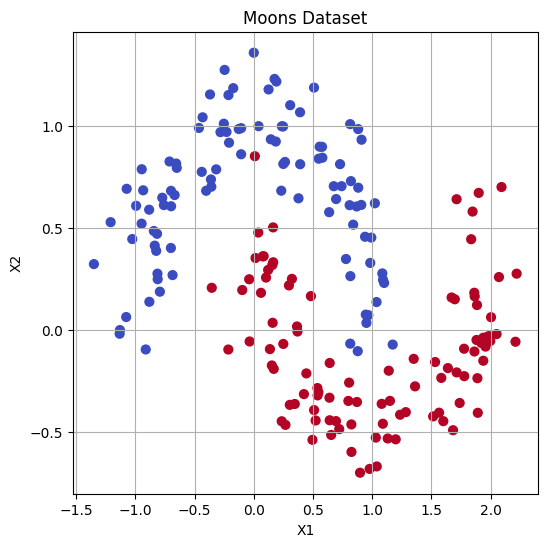


💡 Hint: Use the same structure as CircleClassifier!
💡 Try experimenting with different architectures:
   - Change the number of hidden layers
   - Change the number of neurons per layer
   - Try different activation functions (Tanh, LeakyReLU, etc.)


In [47]:
# Generate moons dataset
np.random.seed(42)
X_moons, y_moons = make_moons(n_samples=200, noise=0.15, random_state=42)

# Convert to tensors
X_moons_tensor = torch.FloatTensor(X_moons)
y_moons_tensor = torch.FloatTensor(y_moons).unsqueeze(1)

print("=" * 60)
print("Moons Dataset Generated")
print("=" * 60)
print(f"Shape: {X_moons.shape}")
print(f"Class distribution: {np.bincount(y_moons)}")
print("=" * 60)


plot_2d_classification(
    X=X_moons,
    y=y_moons,
    model=None,
    title="Bonus Challenge: Interleaving Moons",
    show_boundary=False
)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='coolwarm', s=40)
plt.title("Moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()



# TODO: Your turn!
# 1. Create a new MLP class called MoonClassifier
# 2. Train it on X_moons_tensor and y_moons_tensor
# 3. Visualize the decision boundary
# 4. Compare linear vs. MLP performance

print("\n💡 Hint: Use the same structure as CircleClassifier!")
print("💡 Try experimenting with different architectures:")
print("   - Change the number of hidden layers")
print("   - Change the number of neurons per layer")
print("   - Try different activation functions (Tanh, LeakyReLU, etc.)")

In [51]:
class MoonClassifier(nn.Module):
    """
    Multi-Layer Perceptron for Moon Dataset
"""


    def __init__(self, input_dim=2, hidden_dim1=16, hidden_dim2=8):
        super(MoonClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # input_dim → hidden_dim1
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # hidden_dim1 → hidden_dim2
        self.fc3 = nn.Linear(hidden_dim2, 1)  # hidden_dim2 → 1 (binary classification)
        self.relu = nn.ReLU()      # ReLU for hidden layers
        self.sigmoid = nn.Sigmoid()   # Sigmoid for output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x



    #Create and train model
    torch.manual_seed(42)
    model_moons = MoonClassifier()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_moons.parameters(), lr=0.01)

    losses = []
    for epoch in range(500):
      predictions = model_moons(X_moons_tensor)
      loss = criterion(predictions, y_moons_tensor)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

    #Evaluate
    with torch.no_grad():
      final_predictions = model_moons(X_moons_tensor)
      predicted_classes = (final_predictions > 0.5).int().squeeze()
      accuracy_moons = (predicted_classes == y_moons_tensor.squeeze()).float().mean()

    print("=" * 60)
    print("Moons Challenge Results")
    print("=" * 60)
    print(f"Final Loss: {losses[-1]:.4f}")
    print(f"Accuracy: {accuracy_moons.item()*100:.1f}%")
    print("=" * 60)

    # Visualize result
    plot_2d_classification(
        X_moons, y_moons,
        title="MLP Solution: Moons Dataset",
        show_boundary=False,
        model=model_moons,
        show_probabilities=True
    )

    print("\n✓ Challenge complete! The MLP successfully learned the moon pattern.")


Moons Challenge Results
Final Loss: 0.0048
Accuracy: 100.0%

✓ Challenge complete! The MLP successfully learned the moon pattern.


### Bonus Solution

Here's one possible solution for the moons dataset:

In [52]:
# Solution: MLP for moons dataset
class MoonClassifier(nn.Module):
    """MLP classifier for the moons dataset"""

    def __init__(self, input_dim=2, hidden_dim1=16, hidden_dim2=8):
        super(MoonClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create and train model
torch.manual_seed(42)
model_moons = MoonClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_moons.parameters(), lr=0.01)

losses_moons = []
for epoch in range(500):
    predictions = model_moons(X_moons_tensor)
    loss = criterion(predictions, y_moons_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_moons.append(loss.item())

# Evaluate
with torch.no_grad():
    final_predictions = model_moons(X_moons_tensor)
    predicted_classes = (final_predictions > 0.5).int().squeeze()
    accuracy_moons = (predicted_classes == y_moons_tensor.squeeze()).float().mean()

print("=" * 60)
print("Moons Challenge Results")
print("=" * 60)
print(f"Final Loss: {losses_moons[-1]:.4f}")
print(f"Accuracy: {accuracy_moons.item()*100:.1f}%")
print("=" * 60)

# Visualize result
plot_2d_classification(
    X_moons, y_moons,
    title="MLP Solution: Moons Dataset",
    show_boundary=False,
    model=model_moons,
    show_probabilities=True
)

print("\n✓ Challenge complete! The MLP successfully learned the moon pattern.")

Moons Challenge Results
Final Loss: 0.0048
Accuracy: 100.0%

✓ Challenge complete! The MLP successfully learned the moon pattern.
